# Basis embedding (qiskit)

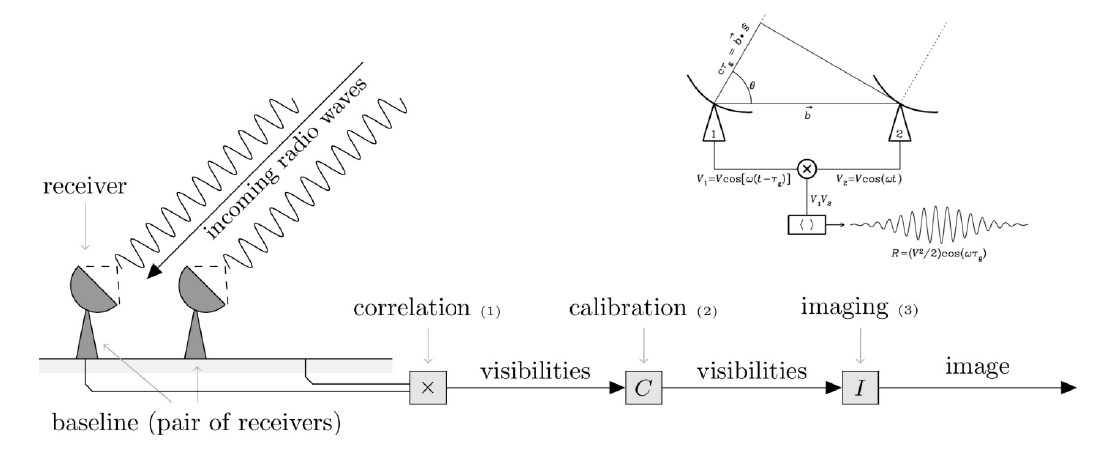

*First pipeline:*
* **1. Data preparation (correlation step):**
    * 1.1 image initialization (spatial domain)
    * 1.2 Fourier transform (frequency domain)
    
    &rarr; simulates radio visibility data
* **2. Data embedding (calibration step):**
    * 2.1 data pre-processing
    * 2.2 data encoding
    
    &rarr; embeds visibilities into qubits
* **3. Data reading (imaging step):**
    * 3.1 readout
    * 3.2 inverse Fourier transform (spatial domain) - IFT
    
    &rarr; approximates science-ready intermediate product  

*Second pipeline:*
* **1. Data preparation (correlation step):**
     * 1.1 image initialization (spatial domain)
     * 1.2 Fourier transform (frequency domain)
     
     &rarr; simulates radio visibility data
* **2. Data embedding (calibration step):**
    * 2.1 data pre-processing
    * 2.2 data encoding
    * 2.3 quantum inverse Fourier transform - QFT
    
    &rarr; embeds visibilities into qubits and applies QFT on qubits
* **3. Data reading (imaging step):**
    * 3.1 readout
    
    &rarr; approximates science-ready intermediate product  

*Basis embedding:*

* circuit family #1 from [Cortese 2018](https://arxiv.org/abs/1803.01958)
* to many features for PennyLane's implementation ([Teamplates](https://docs.pennylane.ai/en/stable/introduction/templates.html))

#### Prerequisites

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import struct

import qiskit
from qiskit import *

In [2]:
# float to binary 
def float_to_bin_real(num):
    return format(struct.unpack('!I', struct.pack('!f', num))[0], '032b')
def float_to_bin_imag(num):
    return format(struct.unpack('!I', struct.pack('!f', num))[0], '032b')

# binary to float
def bin_to_float_real(binary):
    return struct.unpack('!f',struct.pack('!I', int(binary, 2)))[0]
def bin_to_float_imag(binary):
    return struct.unpack('!f',struct.pack('!I', int(binary, 2)))[0]

# reverse a string (for the measurement step readout)
def reverse(string):
    string = string[::-1]
    return string

## 1. Data preparation (correlation step)

### 1.1 image initialization (spatial domain)

In [3]:
# image of the sky filled with double precision complex floats 
# few pixels are set to relatively large complex random values in random spots (image sources)
# relatively small complex values are added (white noise from background radiations) 

n = 10 #number of antennas

sky_image = np.zeros((n, n), dtype='complex64')
mask = np.zeros((n, n), dtype='bool')
stars = np.random.randint(3, 11) #random number of sources
radius = np.random.randint(1, 3) #with random radius

for i in range(0, stars):
    index_i = np.random.randint(0, sky_image.shape[0]-radius)
    index_j = np.random.randint(0, sky_image.shape[1]-radius)
    for j in range(0, radius):
        for k in range(0, radius):
            sky_image[index_i+j][index_j+k] = complex(np.random.rand()*100, np.random.rand()*100)
            mask[index_i+j][index_j+k] = True
            
sky_image.real += np.random.randn(n,n)/100
sky_image.imag += np.random.randn(n,n)/100

print(sky_image)

[[-1.55146243e-02+1.21456627e-02j  1.17636109e-02+1.03480769e-02j
  -7.16474326e-03+1.55710168e-02j -5.29348326e-04-5.46179852e-03j
  -1.56722544e-03+5.41039836e-03j  2.16522440e-03+1.41629931e-02j
  -1.10021466e-03+6.69769524e-03j -1.28169246e-02-3.66384489e-03j
   3.75322304e+01+8.53659286e+01j  1.73517670e-02+3.22463783e-03j]
 [-4.98486543e-03-5.70702972e-03j -9.93128773e-03-7.44335260e-03j
   1.93123973e-03+1.44906361e-02j  1.09488387e-02+1.48589222e-03j
  -1.88509542e-02-5.53922448e-03j  3.32203255e+01+3.31423607e+01j
  -3.34977545e-03+5.86801488e-03j -1.12858927e-02-4.17678384e-03j
  -4.99644270e-03-3.02265235e-03j -1.70332752e-03+2.17070915e-02j]
 [ 2.34751757e-02+2.17866488e-02j -4.10320750e-03+6.83905929e-03j
   7.29391556e+01+7.23490448e+01j  8.61857086e-03-7.69989099e-03j
  -4.53227112e-04-1.32409995e-02j -1.04058385e-02-1.41271884e-02j
   7.93658849e-03+7.38208741e-03j  5.12635102e-03-1.11927651e-02j
  -2.01786980e-02+3.92192556e-03j -8.66242044e-05-1.41296340e-02j]
 [ 9.26

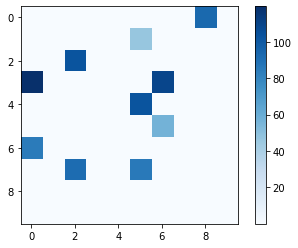

In [4]:
modulus = np.absolute(sky_image)
plt.imshow(modulus, cmap='Blues')
plt.colorbar();

### 1.2 Fourier transform (frequency domain)

In [5]:
visibilities = np.fft.fft2(sky_image).astype('complex64')
print(visibilities)

[[ 566.8438   +584.13983j      2.732504  -40.020554j
   363.3823    -78.81406j    -98.76979  -131.46663j
   176.50717  +242.77667j    319.6163   +196.33266j
   249.83995  +347.5332j     116.08968  -466.5816j
   148.1967   +256.11227j    -70.6042   -144.74792j  ]
 [ -67.948166 -267.30685j    -16.527023 +148.47986j
  -323.58517  -154.45963j    183.40616   -66.44524j
    47.59679   -70.91796j     25.902912  -71.181915j
  -110.36171   -47.860455j  -229.97278   +41.71656j
    89.8003   -262.77197j    141.53223  +125.26117j  ]
 [ -56.26012  -166.3452j    -309.3989   -151.00424j
  -279.01956   +34.096798j   -54.662193  -42.019627j
   255.41695  -122.880684j   -89.81458  -137.79976j
  -275.6707   -179.47983j   -312.75604   +62.164013j
   -20.857298  -70.438705j   221.92902   -94.21925j  ]
 [ 224.03305  +396.61005j   -202.32591  +272.02878j
   308.4934   +136.66609j   -190.03535   +80.45778j
   322.4681    +68.17569j   -144.07053  +453.05844j
   165.63065  +215.42455j    -59.546665 +193.24834j


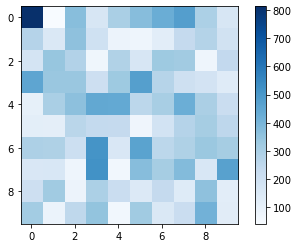

In [6]:
modulus = np.absolute(visibilities)
plt.imshow(modulus, cmap='Blues')
plt.colorbar();

#### * Sanity check

In [7]:
img = np.fft.ifft2(visibilities).astype('complex64')

test_real = ((sky_image.real - img.real)**2).mean()
test_imag = ((sky_image.imag - img.imag)**2).mean()
 
print('Reals MSE: '+ str(test_real))
print('Imaginaries MSE: '+ str(test_imag))

Reals MSE: 2.2951392e-13
Imaginaries MSE: 2.2289817e-13


## 2. Data embedding (calibration step)

### 2.1 data pre-processing
### 2.2 data encoding

In [8]:
# encoding binary data onto qubits
def circuit1(qc, binary, off_set):
    
    for i in range(0, len(binary)):
        qc.reset(off_set+i) # set quantum state |0> by default for all qubits

        if binary[i]=='1':
            qc.x(off_set+i) # act as a CX (controlled X gate)
    
    off_set += len(binary)

    return off_set

In [9]:
number_of_entries = visibilities.shape[0] * visibilities.shape[1]
number_of_bits_real = 32
number_of_bits_imag = 32
number_of_bits = number_of_bits_real + number_of_bits_imag
off_set = 0

# encoding (n bits encoded onto n qubits)
qc = QuantumCircuit(number_of_entries*number_of_bits)
for i in range(0, visibilities.shape[0]):
    for j in range(0, visibilities.shape[1]):
            binary_real = float_to_bin_real(visibilities[i, j].real)
            binary_imag = float_to_bin_imag(visibilities[i, j].imag)
            binary = binary_real+binary_imag
            off_set = circuit1(qc, binary, off_set)

## 3. Data reading

### 3.1 readout

In [10]:
# measurement
qc.measure_all()
backend = Aer.get_backend('aer_simulator') # Qiskit's staple simulator (CHOICE MOTIVATION?)
job = backend.run(qc, shots=1, memory=True) 
output = job.result().get_memory()[0]
out = reverse(output)

# readout
chunks_real = []
chunks_imag = []
for i in range(0, number_of_entries):
    chunks_real.append(out[number_of_bits*i:(number_of_bits*i)+number_of_bits_real]) # real parts represented every 64 bits starting from the first one
    chunks_imag.append(out[(number_of_bits*i)+number_of_bits_imag:(number_of_bits*i)+number_of_bits_imag+number_of_bits_imag]) # imaginary parts represented every 64 bits starting after the first occurence of a real part 

readout = []
for i in range(0, len(chunks_real)):
    readout.append(complex(bin_to_float_real(chunks_real[i]), bin_to_float_imag(chunks_imag[i]))) 

readout = np.array(readout).reshape(n , n).astype('complex64')
print(readout)

[[ 566.8438   +584.13983j      2.732504  -40.020554j
   363.3823    -78.81406j    -98.76979  -131.46663j
   176.50717  +242.77667j    319.6163   +196.33266j
   249.83995  +347.5332j     116.08968  -466.5816j
   148.1967   +256.11227j    -70.6042   -144.74792j  ]
 [ -67.948166 -267.30685j    -16.527023 +148.47986j
  -323.58517  -154.45963j    183.40616   -66.44524j
    47.59679   -70.91796j     25.902912  -71.181915j
  -110.36171   -47.860455j  -229.97278   +41.71656j
    89.8003   -262.77197j    141.53223  +125.26117j  ]
 [ -56.26012  -166.3452j    -309.3989   -151.00424j
  -279.01956   +34.096798j   -54.662193  -42.019627j
   255.41695  -122.880684j   -89.81458  -137.79976j
  -275.6707   -179.47983j   -312.75604   +62.164013j
   -20.857298  -70.438705j   221.92902   -94.21925j  ]
 [ 224.03305  +396.61005j   -202.32591  +272.02878j
   308.4934   +136.66609j   -190.03535   +80.45778j
   322.4681    +68.17569j   -144.07053  +453.05844j
   165.63065  +215.42455j    -59.546665 +193.24834j


### 3.2 inverse Fourier transform (spatial domain)

In [11]:
img = np.fft.ifft2(readout).astype('complex64')

#### fidelity test

In [12]:
test_real = ((sky_image.real - img.real)**2).mean()
test_imag = ((sky_image.imag - img.imag)**2).mean()

print('Reals MSE: '+ str(test_real))
print('Imaginaries MSE: '+ str(test_imag))

Reals MSE: 2.2951392e-13
Imaginaries MSE: 2.2289817e-13


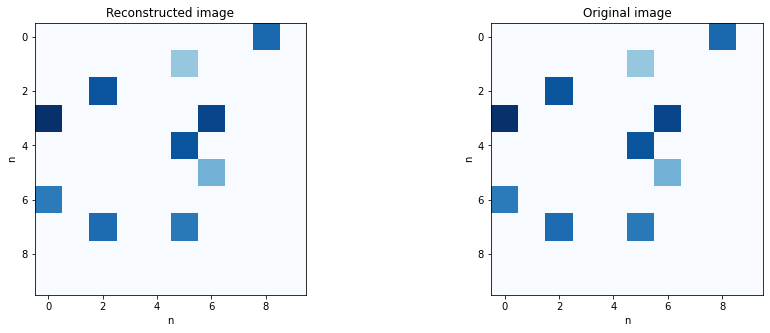

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
modulus1 = np.absolute(img)
modulus2 = np.absolute(sky_image)

axs[0].imshow(modulus1, cmap='Blues')
axs[1].imshow(modulus2, cmap='Blues')

axs[0].set_title("Reconstructed image")
axs[1].set_title("Original image")

for ax in axs.flat:
    ax.set(xlabel='n', ylabel='n')